In [1]:
import pickle
import gym
import time
import numpy as np 
import random
import torch
from run_test import *
%matplotlib inline
import matplotlib.pylab as plt


Logging to /tmp/openai-2018-11-28-22-45-18-784976


set up the code for running trajectories with pong


In [2]:
#try it just for two trajectories

env_id = "BreakoutNoFrameskip-v4"
env_type = "atari"

#env id, env type, num envs, and seed
env = make_vec_env(env_id, 'atari', 1, 0,
                   wrapper_kwargs={
                       'clip_rewards':False,
                       'episode_life':False,
                   })


env = VecFrameStack(env, 4)
agent = PPO2Agent(env, env_type)
#agent = RandomAgent(env.action_space)

/home/dsbrown/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:

def normalize_state(obs):
    obs_highs = env.observation_space.high
    obs_lows = env.observation_space.low
    #print(obs_highs)
    #print(obs_lows)
    #return  2.0 * (obs - obs_lows) / (obs_highs - obs_lows) - 1.0
    return obs / 255.0


In [4]:
checkpoint_min = 100
checkpoint_max = 3600
checkpoint_step = 100
checkpoints = []
for i in range(checkpoint_min, checkpoint_max + checkpoint_step, checkpoint_step):
    if i < 1000:
        checkpoints.append('00' + str(i))
    elif i < 10000:
        checkpoints.append('0' + str(i))
print(checkpoints)

['00100', '00200', '00300', '00400', '00500', '00600', '00700', '00800', '00900', '01000', '01100', '01200', '01300', '01400', '01500', '01600', '01700', '01800', '01900', '02000', '02100', '02200', '02300', '02400', '02500', '02600', '02700', '02800', '02900', '03000', '03100', '03200', '03300', '03400', '03500', '03600']


In [5]:
demonstrations = []
learning_returns = []
for checkpoint in checkpoints:
    
    model_path = "./models/breakout/checkpoints/" + checkpoint
    
    agent.load(model_path)
    episode_count = 1
    for i in range(episode_count):
        done = False
        traj = []
        r = 0
        
        ob = env.reset()
        #traj.append(ob)
        #print(ob.shape)
        steps = 0
        acc_reward = 0
        while True:
            action = agent.act(ob, r, done)
            ob, r, done, _ = env.step(action)
            #print(ob.shape)
            traj.append(normalize_state(ob))
            steps += 1
            acc_reward += r[0]
            if done:
                print("checkpoint: {}, steps: {}, return: {}".format(checkpoint, steps,acc_reward))
                break
        print("traj length", len(traj))
        print("demo length", len(demonstrations))
        if acc_reward not in learning_returns:
            demonstrations.append(traj)
            learning_returns.append(acc_reward)
    


env.close()


    
    
print(learning_returns)

checkpoint: 00100, steps: 389, return: 6.0
traj length 389
demo length 0
checkpoint: 00200, steps: 421, return: 7.0
traj length 421
demo length 1
checkpoint: 00300, steps: 755, return: 23.0
traj length 755
demo length 2
checkpoint: 00400, steps: 961, return: 30.0
traj length 961
demo length 3
checkpoint: 00500, steps: 905, return: 35.0
traj length 905
demo length 4
checkpoint: 00600, steps: 1158, return: 36.0
traj length 1158
demo length 5
checkpoint: 00700, steps: 1619, return: 91.0
traj length 1619
demo length 6
checkpoint: 00800, steps: 1264, return: 62.0
traj length 1264
demo length 7
checkpoint: 00900, steps: 850, return: 41.0
traj length 850
demo length 8
checkpoint: 01000, steps: 1130, return: 54.0
traj length 1130
demo length 9
checkpoint: 01100, steps: 1388, return: 67.0
traj length 1388
demo length 10
checkpoint: 01200, steps: 1841, return: 160.0
traj length 1841
demo length 11
checkpoint: 01300, steps: 1218, return: 63.0
traj length 1218
demo length 12
checkpoint: 01400, ste

Let's plot the returns to see if they are roughly monotonically increasing.

In [1]:
plt.plot(learning_returns)
plt.xlabel("Demonstration")
plt.ylabel("Return")
plt.savefig("breakoutLearningPPO.png")
plt.show()

NameError: name 'plt' is not defined

36
36
[6.0, 7.0, 23.0, 30.0, 35.0, 36.0, 91.0, 62.0, 41.0, 54.0, 67.0, 160.0, 63.0, 102.0, 145.0, 242.0, 264.0, 301.0, 75.0, 338.0, 171.0, 366.0, 364.0, 94.0, 345.0, 204.0, 412.0, 347.0, 371.0, 69.0, 401.0, 331.0, 405.0, 381.0, 95.0, 407.0]
[6.0, 7.0, 23.0, 30.0, 35.0, 36.0, 91.0, 62.0, 41.0, 54.0, 67.0, 160.0, 63.0, 102.0, 145.0, 242.0, 264.0, 301.0, 75.0, 338.0, 171.0, 366.0, 364.0, 94.0, 345.0, 204.0, 412.0, 347.0, 371.0, 69.0, 401.0, 331.0, 405.0, 381.0, 95.0, 407.0]


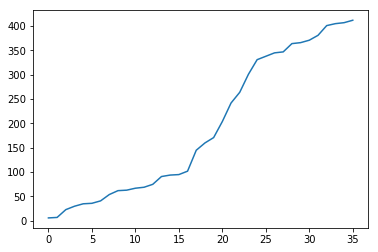

In [7]:
print(len(learning_returns))
print(len(demonstrations))
print([a[0] for a in zip(learning_returns, demonstrations)])
#cheat and sort them to see if it helps learning
sorted_demos = [x for _, x in sorted(zip(learning_returns,demonstrations), key=lambda pair: pair[0])]

sorted_returns = sorted(learning_returns)
print(learning_returns)
plt.plot(sorted_returns)

Split the data into train and validation sets

In [8]:
train_demos = []
train_returns = []
valid_demos = []
valid_returns = []

for i,d in enumerate(sorted_demos):
    print(i)
    if i % 5 is not 4:
        train_demos.append(d)
        train_returns.append(sorted_returns[i])
    else:
        valid_demos.append(d)
        valid_returns.append(sorted_returns[i])

print(train_returns)
print(valid_returns)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
[6.0, 7.0, 23.0, 30.0, 36.0, 41.0, 54.0, 62.0, 67.0, 69.0, 75.0, 91.0, 95.0, 102.0, 145.0, 160.0, 204.0, 242.0, 264.0, 301.0, 338.0, 345.0, 347.0, 364.0, 371.0, 381.0, 401.0, 405.0, 412.0]
[35.0, 63.0, 94.0, 171.0, 331.0, 366.0, 407.0]


In [2]:
import numpy as np
demoer_returns = [6.0, 7.0, 23.0, 30.0, 36.0, 41.0, 54.0, 62.0, 67.0, 69.0, 75.0, 91.0, 95.0, 102.0, 145.0, 160.0, 204.0, 242.0, 264.0, 301.0, 338.0, 345.0, 347.0, 364.0, 371.0, 381.0, 401.0, 405.0, 412.0]
print(len(demoer_returns))
[np.max(demoer_returns),  np.min(demoer_returns), np.mean(demoer_returns)]

29


[412.0, 6.0, 187.51724137931035]

Now I want to build a neural network to predict the reward the learner is trying to optimize. The inputs are 84x84x4 grayscale images. I'm going to try and use the NIPS architecture from DeepMind.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cuda:0


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 16, 7, stride=3)
        self.conv2 = nn.Conv2d(16, 16, 5, stride=2)
        self.conv3 = nn.Conv2d(16, 16, 3, stride=1)
        self.conv4 = nn.Conv2d(16, 16, 3, stride=1)
        self.fc1 = nn.Linear(1936, 64)
        self.fc2 = nn.Linear(64, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2) #get into NCHW format
            #compute forward pass of reward network
            x = F.leaky_relu(self.conv1(x))
            x = F.leaky_relu(self.conv2(x))
            x = x.view(-1, 1936)
            x = F.leaky_relu(self.fc1(x))
            r = torch.sigmoid(self.fc2(x)) #clip reward?
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 8, 8, stride=4)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2)
        self.fc1 = nn.Linear(9*9*16, 1)
        #self.fc2 = nn.Linear(256, 1)
        
        
    def cum_return(self, traj):
        '''calculate cumulative return of trajectory'''
        sum_rewards = 0
        for x in traj:
            x = x.permute(0,3,1,2)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(-1, 9*9*16)
            r = torch.tanh(self.fc1(x))
            
            sum_rewards += r
        ##    y = self.scalar(torch.ones(1))
        ##    sum_rewards += y
        #print(sum_rewards)
        return sum_rewards
        
            
    
    def forward(self, traj_i, traj_j):
        '''compute cumulative return for each trajectory and return logits'''
        #print([self.cum_return(traj_i), self.cum_return(traj_j)])
        return torch.cat([self.cum_return(traj_i), self.cum_return(traj_j)])
    


Now we train the network. I'm just going to do it one by one for now. Could adapt it for minibatches to get better gradients

In [11]:
def learn_reward(reward_network, optimizer, trajectories, num_iter):
    loss_criterion = nn.CrossEntropyLoss()
    #print(training_data[0])
    cum_loss = 0.0
    for epoch in range(num_iter):
        #pick two random trajectories, traj_i and traj_j and give classification label to later one
        j = np.random.randint(len(trajectories)) 
        i = np.random.randint(len(trajectories))
        while(i == j):
            i = np.random.randint(len(trajectories))
        #print(i,j)
        #traj_i = np.array([[d[0]] for d in trajectories[i]])
        #traj_j = np.array([[d[0]] for d in trajectories[j]])
        traj_i = np.array(trajectories[i])
        traj_j = np.array(trajectories[j])
        if i > j:
            labels = np.array([[0]])
        else:
            labels = np.array([[1]])
            
        traj_i = torch.from_numpy(traj_i).float().to(device)
        traj_j = torch.from_numpy(traj_j).float().to(device)
        labels = torch.from_numpy(labels).to(device)
        
        #zero out gradient
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = reward_network.forward(traj_i, traj_j).unsqueeze(0)
        #print(outputs)
        #print(labels)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print stats to see if learning
        item_loss = loss.item()
        cum_loss += item_loss
        if epoch % 50 == 49:
            #with torch.no_grad():
            #    print(torch.cat([reward_network.cum_return(torch.from_numpy(np.array(traj)).float()) for traj in trajectories]))
            print(epoch, cum_loss / 50)
            cum_loss = 0.0
    print("finished training")



        
    

Now we create a reward network and optimize it using the training data.

Trying shorter snippets of the demos, should use a sliding window over all demos to get lots of training data, but just  trying the last H frames for now, where H is length of first (the shortest) demo 

In [13]:
H = len(train_demos[0])
print(H)
demos_fh = [d[len(d)-40:] for d in train_demos]
print(len(demos_fh))
reward_fh = Net()
reward_fh.to(device)
import torch.optim as optim
optimizer = optim.Adam(reward_fh.parameters(),  lr = 0.0001)
learn_reward(reward_fh, optimizer, demos_fh, 1000)

389
29
49 0.4742085266113281
99 0.1570914077758789
149 0.10331291198730469
199 0.09162956237792969
249 0.09894823074340821
299 0.04204460144042969
349 0.09055571556091309
399 0.12380776405334473
449 0.033943500518798825
499 0.07395833015441894
549 0.09635259628295899
599 0.06289568901062012
649 0.08512200355529785
699 0.06989073753356934
749 0.05971731185913086
799 0.037376699447631834
849 0.04738187789916992
899 0.041250724792480466
949 0.07062639236450195
999 0.0726793098449707
finished training


See what predicted returns look like compared to actual

In [16]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in train_demos]
for i, p in enumerate(pred_returns):
    print(i,p,train_returns[i])

0 45.053611755371094 6.0
1 52.050079345703125 7.0
2 106.51529693603516 23.0
3 145.15286254882812 30.0
4 171.18826293945312 36.0
5 131.7396697998047 41.0
6 223.71356201171875 54.0
7 245.16802978515625 62.0
8 256.8270568847656 67.0
9 257.8382568359375 69.0
10 268.984375 75.0
11 338.8718566894531 91.0
12 266.70562744140625 95.0
13 313.43316650390625 102.0
14 358.41876220703125 145.0
15 457.1098937988281 160.0
16 604.6179809570312 204.0
17 381.4294128417969 242.0
18 761.8514404296875 264.0
19 708.5474853515625 301.0
20 675.5497436523438 338.0
21 756.9134521484375 345.0
22 1077.0540771484375 347.0
23 760.2745361328125 364.0
24 831.0755004882812 371.0
25 755.2693481445312 381.0
26 3648.254638671875 401.0
27 7866.90234375 405.0
28 1074.2862548828125 412.0


In [15]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 137.09326171875 35.0
1 207.361328125 63.0
2 268.4431457519531 94.0
3 432.5416564941406 171.0
4 491.7622985839844 331.0
5 857.0635986328125 366.0
6 1284.317138671875 407.0


40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
40
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


/home/dsbrown/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


26
27
28


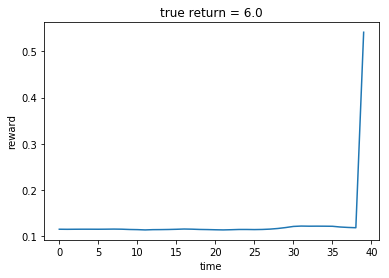

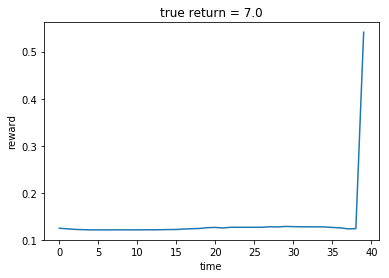

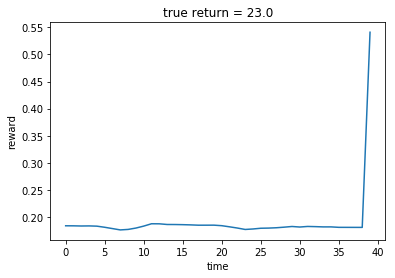

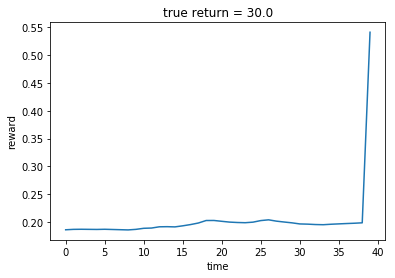

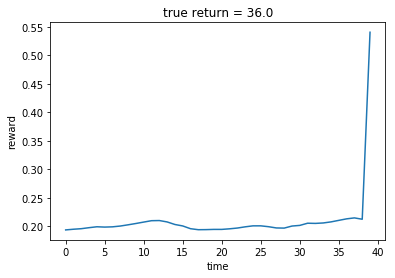

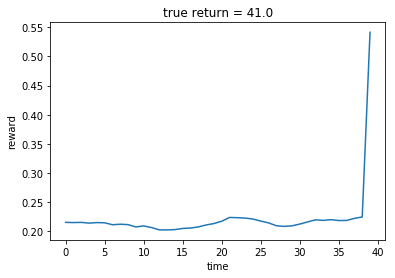

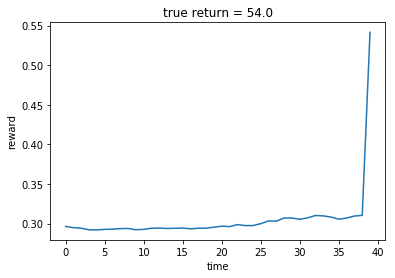

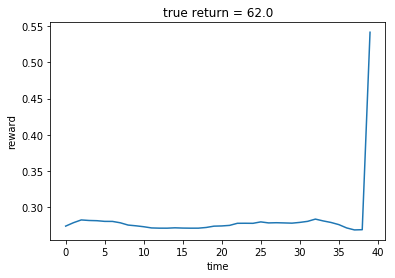

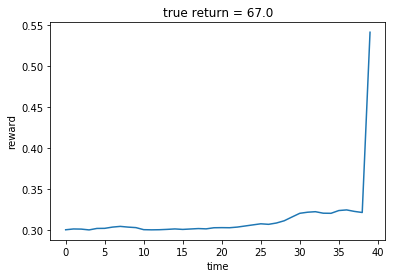

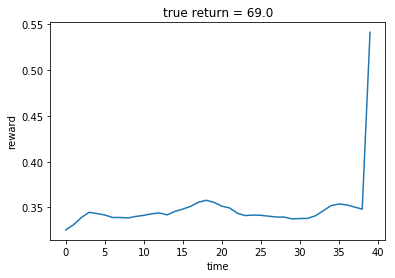

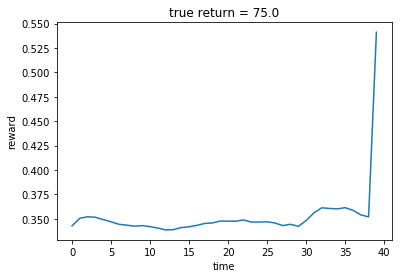

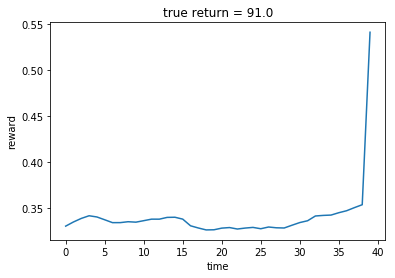

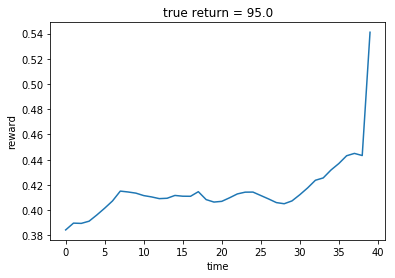

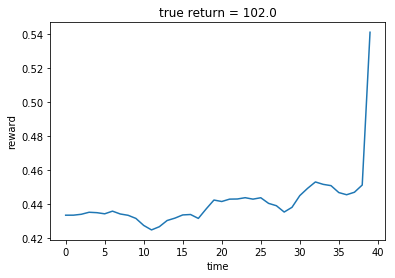

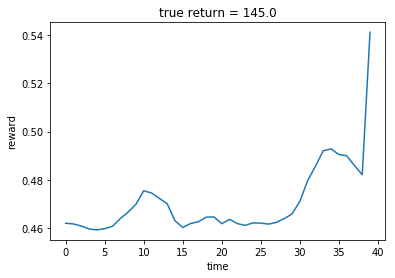

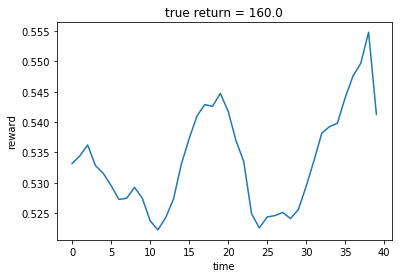

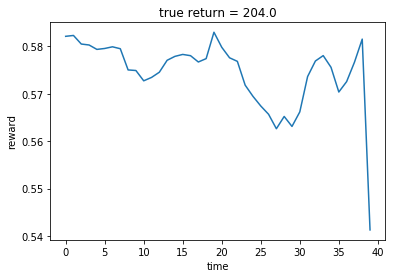

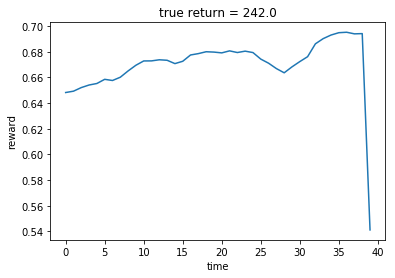

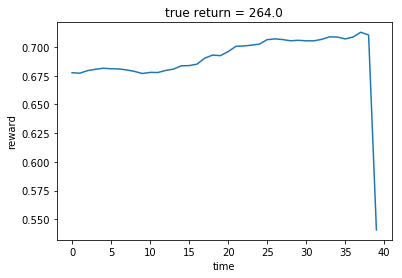

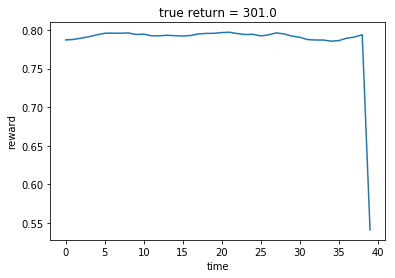

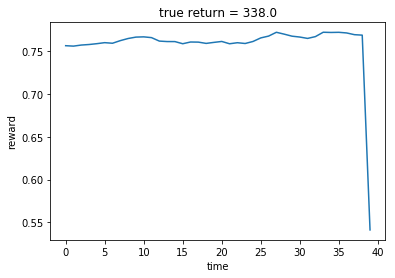

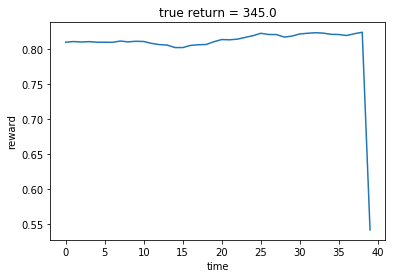

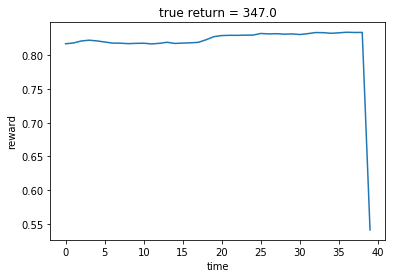

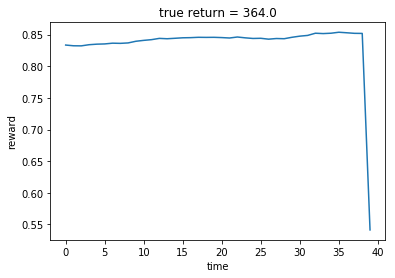

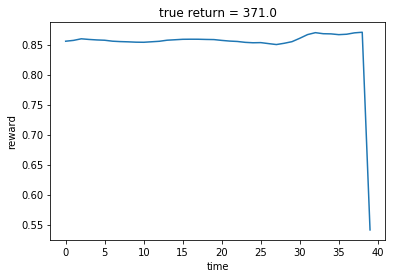

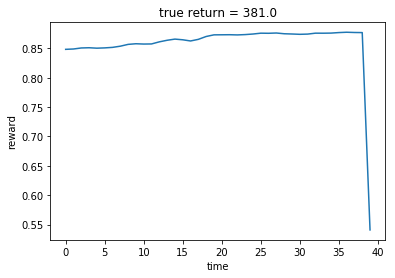

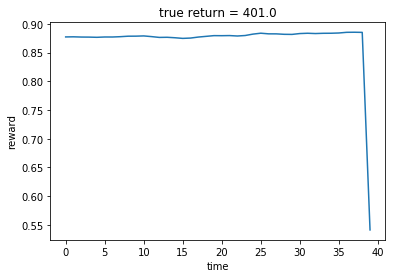

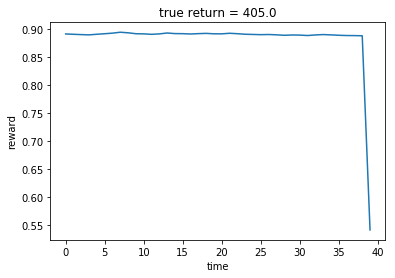

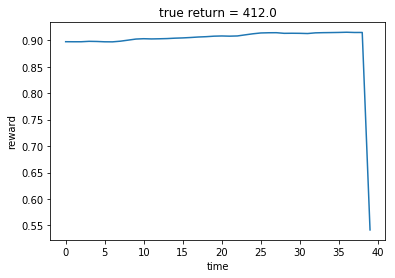

In [21]:
#print out the actual time series of rewards predicted by nnet for each trajectory.
#They are monotonically increasing, so that's good!
for d in demos_fh:
    print(len(d))

cnt = 0
with torch.no_grad():
    for d in demos_fh:
        rewards = []
        print(cnt)
        for s in d:
            r = reward_fh.cum_return(torch.from_numpy(np.array([s])).float().to(device)).item()
            rewards.append(r)
        plt.figure(cnt)
        plt.plot(rewards)
        plt.xlabel("time")
        plt.ylabel("reward")
        plt.title("true return = {}".format(train_returns[cnt]))
        cnt += 1
#plt.savefig("learned_mcar_return.png")
plt.show()

Check validation accuracy

In [21]:
with torch.no_grad():
    pred_returns = [reward_fh.cum_return(torch.from_numpy(np.array(traj)).float().to(device)).item() for traj in valid_demos]
for i, p in enumerate(pred_returns):
    print(i,p,valid_returns[i])

0 158.86569213867188 6.0
1 508.79510498046875 36.0
2 627.7069702148438 67.0


In [20]:
torch.save(reward_fh.state_dict(), "./breakout_all_last40_reward_sorted.params")

Test reloading policy and see why giving zero reward when I run it inside of PPO..

[0.42928225]


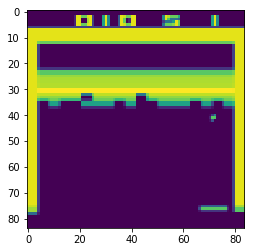

In [47]:
test_net = Net()
test_net.to(device)
test_net.load_state_dict(torch.load("./breakout_1_15_lastXreward_sorted.params"))
obs = demonstrations[10][400]
plt.imshow(obs[0,:,:,3])
with torch.no_grad():
    test_r = test_net.cum_return(torch.from_numpy(np.array([obs])).float().to(device)).cpu().numpy().transpose()[0]
print(test_r)

import pickle
filename = 'rand_obs.pkl'
outfile = open(filename,'wb')
pickle.dump(obs,outfile)
outfile.close()

In [49]:
infile = open(filename,'rb')
new_obs = pickle.load(infile)
infile.close()
(obs == new_obs).all()

True